# Group objects that behave in a similar way
### Assets that behave/trade in a similar way
- Volitility
- Price Return Behavior

In [ ]:
# Silence Warnings
import warnings 
warnings.simplefilter(action="ignore" , category=FutureWarning)

In [6]:
# Fetch/Structure Data
import numpy as np 
import pandas as pd
import yfinance as yf
import pandas_datareader.nasdaq_trader as pdr
from datetime import datetime


# Feature Engineering
from sklearn.preprocessing import  StandardScaler

# Machine Learning
from sklearn.cluster import  KMeans
from sklearn import metrics

# The knee point is the point of maximum curvature.
from kneed import KneeLocator

# Co-Integration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data Extraction

In [7]:
# Data Storage
filename = "data-storage/raw_data_etf.csv"
filename_co_integration = "data-storage/raw_data_conint_pairs.csv"

In [22]:
# Load Saved Data or Fetch
load_existing = True
load_coint_pairs = True

In [9]:
# Time Range
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

### Fetch Data

In [10]:
#  Get New Data
if not load_existing:
    symbols = pdr.get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True)  &  (symbols["Market Category"] == "G")] #global markets
    symbols = list(symbols.index.values)
    
    # # create dataframe with all etf stocks data
    fetched_stocks = []
    for symbol in symbols:
        data = yf.download(symbol ,  start_date , end_date )
        data = data[["Open" , "High" , "Low" , "Close" ]].copy()
        data["Symbol"] = symbol
        fetched_stocks.append(data)
    
    # Save Data
    df = pd.concat(fetched_stocks)
    df.reset_index(inplace=True)
    df = df.pivot(index='Date', columns='Symbol', values='Close')
    df.to_csv(filename)




# READ FILE
else:
    data = pd.read_csv(filename)
    df = data

# Condition Data

In [11]:
# Drop Null Values
if df.isnull().values.any():
    df = df.dropna(axis=1)
    df = df.set_index("Date")

print("Shape: " , df.shape)
df

Shape:  (965, 212)


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIQ,AIRR,ALTY,...,VWOB,VXUS,VYMI,WBND,WCLD,WINC,WIZ,WOOD,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,54.860001,74.910004,80.070000,49.720001,23.665001,24.059999,67.459999,18.298000,28.822001,14.799,...,81.510002,56.310001,64.699997,94.771927,26.111000,25.834999,27.160000,66.820000,43.259998,33.209999
2020-01-03,54.570000,73.720001,79.379997,49.080002,23.555000,24.065001,66.209999,18.190001,29.115000,14.830,...,81.320000,55.619999,63.779999,94.912277,26.120001,25.834999,27.100000,66.269997,42.750000,32.930000
2020-01-06,54.349998,73.419998,79.559998,49.200001,23.565001,24.059999,66.230003,18.230000,29.013000,14.870,...,81.190002,55.700001,63.900002,94.912277,26.586000,25.879999,26.980000,66.150002,42.810001,32.856998
2020-01-07,54.430000,73.680000,79.360001,49.099998,23.650999,24.059999,66.430000,18.340000,28.969999,14.870,...,81.320000,55.599998,63.720001,94.666664,26.620001,25.879999,27.115000,66.120003,42.939999,32.759998
2020-01-08,54.480000,73.839996,79.750000,49.230000,23.763000,24.059999,66.830002,18.430000,28.945000,14.850,...,81.580002,55.700001,63.790001,94.701752,26.941000,25.879999,27.200001,66.120003,43.230000,32.939999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,47.599998,61.669998,89.830002,45.389999,25.040001,22.129999,54.230000,25.850000,46.950001,10.420,...,57.759998,51.490002,59.959999,18.820000,27.270000,23.295000,27.250000,69.580002,48.840000,39.924999
2023-10-26,47.580002,61.220001,88.910004,45.090000,24.610001,22.090000,53.930000,25.500000,47.340000,10.360,...,57.910000,51.200001,59.660000,18.950001,27.070000,23.330000,27.240000,70.150002,48.430000,39.570000
2023-10-27,47.240002,61.270000,88.589996,44.980000,24.490000,22.020000,53.820000,25.670000,46.980000,10.310,...,57.910000,51.060001,59.330002,18.930000,26.930000,23.379999,27.245001,70.040001,48.209999,39.254002


# Feature Engineering
- For Each ETF stock
    - average returns
    - average volitility


In [12]:
# Create Dataframe with Returns and Volitility for each stock

df_returns = pd.DataFrame(df.pct_change().mean() * 255 , columns=["Returns"])
df_returns["Volitility"] = df.pct_change().std() * np.sqrt(255)


df_returns

,Returns,Volitility
AADR,-0.005324,0.261395
AAXJ,-0.023783,0.239495
ACWI,0.055585,0.221041
ACWX,0.001118,0.219636
AGNG,0.034122,0.201862
...,...,...
WINC,-0.024245,0.062052
WIZ,0.021252,0.213475
WOOD,0.055408,0.282768
XT,0.064756,0.251709


### Scaling Dataframe
- To make sure if one column ranges from 1 to 10 and another column ranges from 1000 to 10000

In [13]:
# Scaling Features
scaler = StandardScaler()

# Transform Values to propper scale size
scaler = scaler.fit_transform(df_returns)

# make a new dataframe using the scaled values
scaled_data = pd.DataFrame(scaler , columns=df_returns.columns , index=df_returns.index)
df_scaled = scaled_data


df_scaled

,Returns,Volitility
AADR,-0.271168,0.231927
AAXJ,-0.462667,0.056203
ACWI,0.360726,-0.091878
ACWX,-0.204339,-0.103145
AGNG,0.138054,-0.245766
...,...,...
WINC,-0.467460,-1.367602
WIZ,0.004534,-0.152589
WOOD,0.358881,0.403424
XT,0.455867,0.154201


# K MEANS CLUSTERING

### Obtain Optimal Amount of Clusters
- how many clusters until the inertia dramatically decreases?

In [ ]:
# Make a copy of your scaled dataframe
x = df_scaled.copy()

# Define amount of clusters
k = range(1,16,1)

# Create an empty list where we'll store the sum of squared distances
# (known as inertia) for each number of clusters
distortions = []

# Loop through each number of clusters in our range
for calc in k:
    # Create a KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=calc)
    
    # Fit the KMeans model to our data
    kmeans.fit(x)
    
    # Calculate the model's inertia (sum of squared distances to closest cluster)
    distortions.append(kmeans.inertia_)

# Use the KneeLocator function to find the "elbow point" in our range of clusters
# The elbow point is the number of clusters at which adding more clusters 
# does not significantly decrease the inertia (sum of squared distances).
# In this case, the function is looking for a point where the curve of the 
# distortions plot is convex and decreasing.
k1 = KneeLocator(k , distortions , curve="convex" , direction="decreasing")

# The elbow point (optimum number of clusters) is stored in `c`
Optimal_Amount_Clusters = k1.elbow

# Print out the optimum number of clusters
print("Optimum Clusters" , Optimal_Amount_Clusters)


### Fit AI knn Model

In [15]:
# fit
k_means = KMeans(n_clusters=Optimal_Amount_Clusters)
k_means.fit(x)

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5)

In [16]:
# predict
prediction = k_means.predict(df_scaled)

# Display Results

<function matplotlib.pyplot.show(close=None, block=None)>

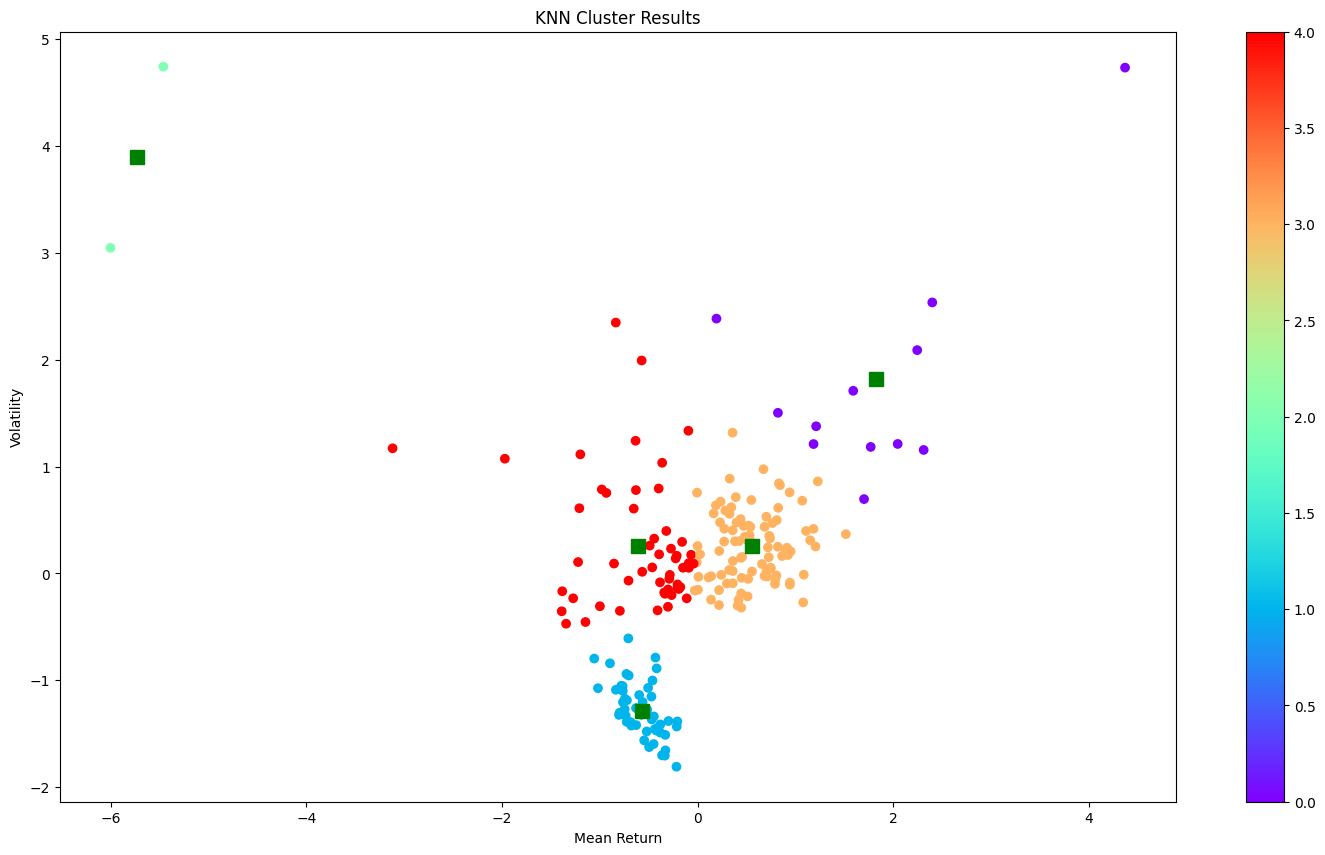

In [17]:
# Obtain the centroids of the clusters from the trained KMeans model.
centroids = k_means.cluster_centers_

# Create a figure to host the plot, with size 18x10.
fig = plt.figure(figsize=(18,10))

# Add a subplot to the figure.
Graphic = fig.add_subplot(111)

# Scatter plot of the data, colored by cluster label.
scatter = Graphic.scatter(x.iloc[:,0], x.iloc[:,1] , c = k_means.labels_, cmap="rainbow" , label=x.index)

# Set the title and labels for the axes of the plot.
Graphic.set_title("KNN Cluster Results")
Graphic.set_xlabel("Mean Return")
Graphic.set_ylabel("Volatility")

# Display a color bar to illustrate which color corresponds to which cluster.
plt.colorbar(scatter)

# Plot the centroids of each cluster as green squares.
plt.plot(centroids[:,0] , centroids[:,1] , "sg" , markersize = 10)
plt.show


In [18]:
# Return Series
clustered_series = pd.Series(index=x.index , data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=x.index , data=k_means.labels_.flatten())

# Remove outliers, denoted by -1, from the series
clustered_series = clustered_series[clustered_series != -1]


clustered_series[:15]

AADR    4
AAXJ    4
ACWI    3
ACWX    4
AGNG    3
AGZD    1
AIA     4
AIQ     3
AIRR    0
ALTY    4
ANGL    1
ASET    4
BBH     3
BFIT    4
BGRN    1
dtype: int32

Text(0.5, 0, 'Cluster')

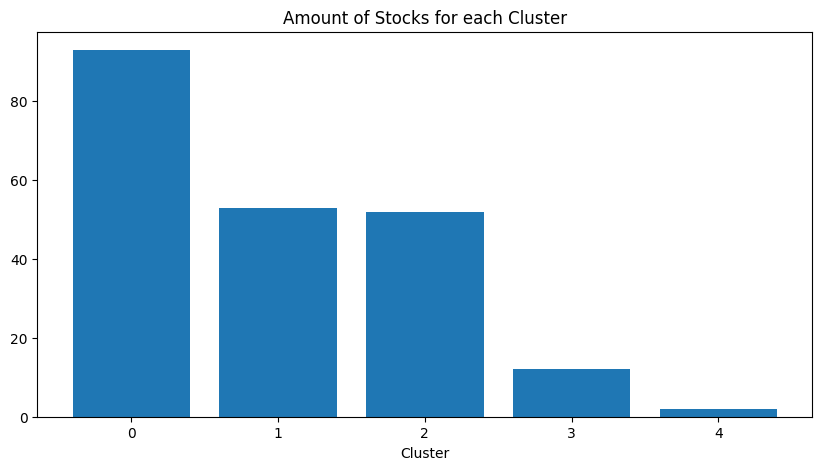

In [19]:
# view number by cluser
plt.figure(figsize=(10,5))

# Generate a bar chart. X-axis is the range of the number of unique clusters. Y-axis is the count of items in each cluster.
plt.bar(range(len(clustered_series.value_counts())) , clustered_series.value_counts())

# Labels
plt.title("Amount of Stocks for each Cluster")
plt.xlabel("Cluster")

In [20]:
# Remove Clusters if preferred
clusters_clean = clustered_series[clustered_series < 3]

print(f"Current Clusters: {len(clustered_series)}")
print(f"Cleaned Clusters: {len(clusters_clean)}")

Current Clusters: 212
Cleaned Clusters: 66


# FIND Cointergrated Stock Pairs (linear-cointergration)
- OLS regression

In [21]:
def calc_cointergration(series_1 , series_2):
    # Initialize flag
    coint_flag = 0
    
    # Perform the Augmented Dickey-Fuller test to check for stationarity
    coint_res = coint(series_1 , series_2)
    
    # Extract t-statistic, p-value and critical values from the test results
    count_t = coint_res[0]
    p_value = coint_res[1]
    critical_val = coint_res[2][1]
    
    # Perform Ordinary Least Squares (OLS) regression to find the hedge ratio
    model = sm.OLS(series_1,series_2).fit()
    hedge_ratio = model.params[0]
    
    # If p-value is less than 0.05 (5% significance level) and t-statistic is less than critical value
    # it means the two series are cointegrated and we set the flag to 1
    coint_flag = 1 if p_value < 0.05 and count_t < critical_val else 0

    return coint_flag , hedge_ratio


- goes through a list of asset pairs
- checks if they belong to the same cluster
- if they are not the same asset. Then, it checks if these pairs of assets are cointegrated
    - meaning they move together over time, and appends the cointegrated pairs to a list.

In [23]:
# Initialize two lists: one for storing tested asset pairs, another for storing cointegrated asset pairs.
tested_pairs = []
cointergrated_pairs = []


if not load_coint_pairs:

    # FIND ALL COINTERGRATIONS
    for base_asset in clusters_clean.index:
        
        # BASE CLUSTER NUMBER
        base_label = clusters_clean[base_asset]

        # COMPARE AGAINST EVERY OTHER TICKER
        for compare_asset in clusters_clean.index:
            
            # COMPARISON CLUSTER NUMBER
            compare_label = clusters_clean[compare_asset]

            # CREATE PAIR STRING FOR REFERENCE & SORT
            test_pair = base_asset + compare_asset
            test_pair = "".join(sorted(test_pair))
            
            # CHECK IF TESTED ALREADY
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            # CHECK IF BELONG TO SAME CLUSTER
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
                # FETCH THEIR DATA
                series_1 = df[base_asset].values.astype(float)
                series_2 = df[compare_asset].values.astype(float)
                
                # FIND OUT IF COINTERGRATED OR NOT
                coint_flag , _ = calc_cointergration(series_1,series_2)
                
                if coint_flag == 1:
                    # Add this pair of assets to the list of cointegrated pairs.
                    cointergrated_pairs.append({
                        "base_asset":base_asset,
                        "compare_asset":compare_asset,
                        "label":base_label
                    })

                    print(f"{test_pair.strip()}\t | {_} | {base_label}" )


    df_coint = pd.DataFrame(cointergrated_pairs).sort_values(by="label")
    df_coint.to_csv(filename_co_integration)

In [24]:
# READ FILE
df_coint = pd.read_csv(filename_co_integration).iloc[:, 1:]

# TSNE DATA

In [25]:
# get unique cointergrated assets
coin_assets = [df_coint["base_asset"].values]
coin_assets.append(df_coint["compare_asset"].values)
coin_unique_assets = np.unique(coin_assets)

coin_unique_assets

array(['ACWI', 'AGNG', 'AGZD', 'ANGL', 'BGRN', 'BND', 'BNDW', 'BNDX',
       'BSCN', 'BSCO', 'BSCP', 'BSCQ', 'BSCR', 'BSCS', 'BSCT', 'BSJN',
       'BSJO', 'BSJP', 'HERD', 'HISF', 'HLAL', 'HNDL', 'HYLS', 'HYXF',
       'HYZD', 'IEF', 'IEI', 'IGIB', 'IGOV', 'IGSB', 'IJT', 'IMCV',
       'INDY', 'ISHG', 'ISHP', 'ISTB', 'IUS', 'IUSB', 'IUSV', 'JSMD',
       'JSML', 'KBWP', 'KNGZ', 'KRMA', 'LDSF', 'LEGR', 'LMBS', 'MBB',
       'MFLX', 'MILN', 'NFTY', 'NXTG', 'NZAC', 'ONEQ', 'PDP', 'PEZ',
       'PFI', 'PFM', 'PHO', 'PIO', 'PKW', 'PPH', 'PRFZ', 'PRN', 'PSC',
       'PSCC', 'PSCI', 'PSCM', 'PSCT', 'PSET', 'PSL', 'PY', 'PYZ', 'QQEW',
       'RDVY', 'RNLC', 'RNMC', 'RNSC', 'ROBT', 'RTH', 'SDG', 'SDVY',
       'SHV', 'SHY', 'SKOR', 'SLQD', 'SNSR', 'SQLV', 'SUSB', 'SUSC',
       'UITB', 'ULVM', 'USTB', 'USVM', 'VCIT', 'VCSH', 'VGIT', 'VGSH',
       'VMBS', 'VONE', 'VONV', 'VRIG', 'VSDA', 'VSMV', 'VTC', 'VTHR',
       'VTIP', 'VTWG', 'VWOB', 'WINC', 'WOOD', 'XT', 'YLDE'], dtype=object)

In [26]:
# Update df_TSNE to contain only the rows with cointergrated assets and their returns and volitility

df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coin_unique_assets)]

df_TSNE

,Returns,Volitility
ACWI,0.360726,-0.091878
AGNG,0.138054,-0.245766
AGZD,-0.436822,-1.457976
ANGL,-0.429858,-0.788122
BGRN,-0.724037,-1.389210
...,...,...
VWOB,-1.055780,-0.797164
WINC,-0.467460,-1.367602
WOOD,0.358881,0.403424
XT,0.455867,0.154201


In [27]:
# Apply t-SNE transformation to df_TSNE with specific parameters
x_tsne = TSNE(learning_rate=30, perplexity=5,random_state=42, n_jobs=-1).fit_transform(df_TSNE)

x_tsne

array([[ 29.552263  ,   6.0071774 ],
       [ 33.877834  ,   5.365446  ],
       [ -6.440252  , -27.551285  ],
       [-27.207085  , -16.84657   ],
       [-35.71839   ,   4.5383964 ],
       [-34.192337  ,   0.07702796],
       [-36.63048   ,   5.2319465 ],
       [-37.15307   ,   6.4781604 ],
       [-11.393117  , -32.762794  ],
       [-11.320931  , -31.23133   ],
       [ -9.282074  , -28.97605   ],
       [-15.088316  , -22.262676  ],
       [-17.751076  , -20.115261  ],
       [-20.254581  , -18.477116  ],
       [-21.174948  , -17.914928  ],
       [-22.763073  , -18.77411   ],
       [-23.74012   , -18.05719   ],
       [-24.973366  , -17.718231  ],
       [ 13.407898  ,   2.950451  ],
       [-31.518072  , -10.739228  ],
       [  6.6673265 ,   3.1189985 ],
       [-34.046757  , -12.939628  ],
       [-34.25662   ,  -8.355039  ],
       [-32.17574   , -11.160744  ],
       [-26.378819  , -17.218708  ],
       [-33.844406  ,  -2.4810116 ],
       [ -3.4774833 , -26.855959  ],
 

# Display TNSE
- this code is creating a map, where each point is an asset (stock). Assets that behave similarly are shown closer together. Lines between points mean those two assets have been found to move together based on a certain statistical test. The different colors represent different groups of assets that are found to be similar. The goal is to visualize how different assets relate to each other.

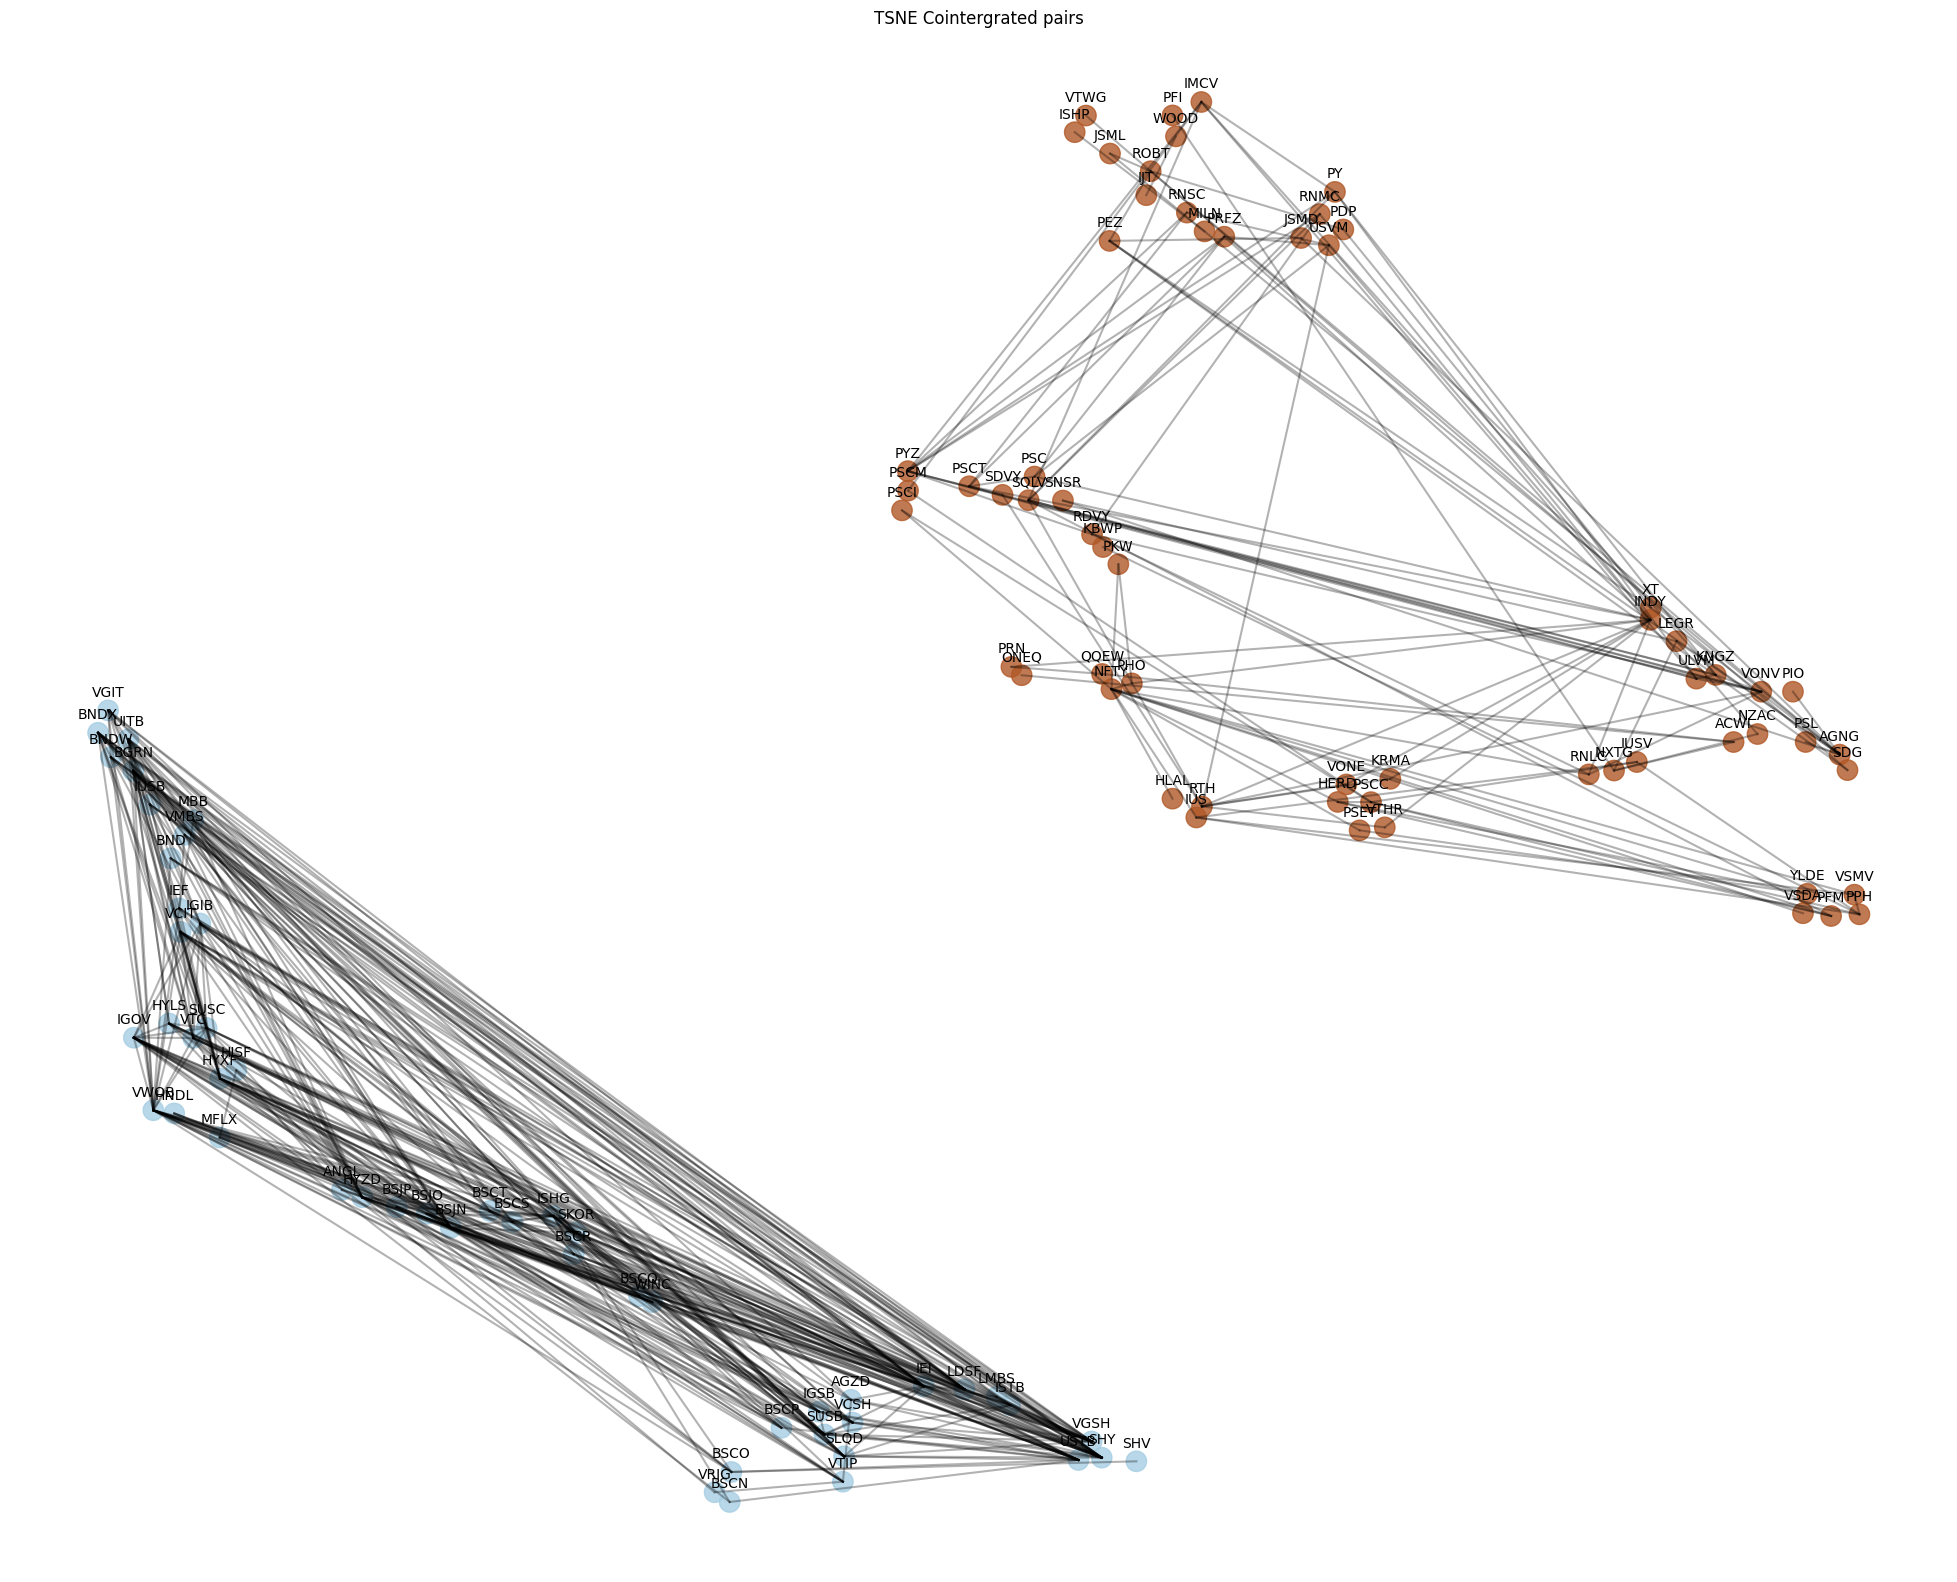

In [28]:
# Get series of clustered pairs
in_pairs_series = clustered_series.loc[coin_unique_assets]

# setup graphic figure
plt.figure(1,figsize=(25,20))
plt.clf()
plt.axis("off")


# Draw line for each pair in df_coint
for index , pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1 , y1 = x_tsne[loc1, :]

    ticker2 = pair[1]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2 , y2 = x_tsne[loc2, :]
    plt.plot([x1,x2] , [y1,y2] , "k-" , alpha=0.3)


# Scatter plot with transformed data and color based on in_pairs_series
plt.scatter(x_tsne[:, 0] , x_tsne[: , 1] , s=215 , alpha=0.8 , c=in_pairs_series.values, cmap=cm.Paired )
plt.title("TSNE Cointergrated pairs")


# Add annotations for each point on the plot
for _x , _y , name in zip(x_tsne[:, 0] , x_tsne[:, 1] , df_TSNE.index):
    label = name
    plt.annotate(label , (_x,_y) , textcoords="offset points" , xytext=(0,10) , ha="center")

# final display
plt.show()

# ----------- Review a Pair's Price -----------

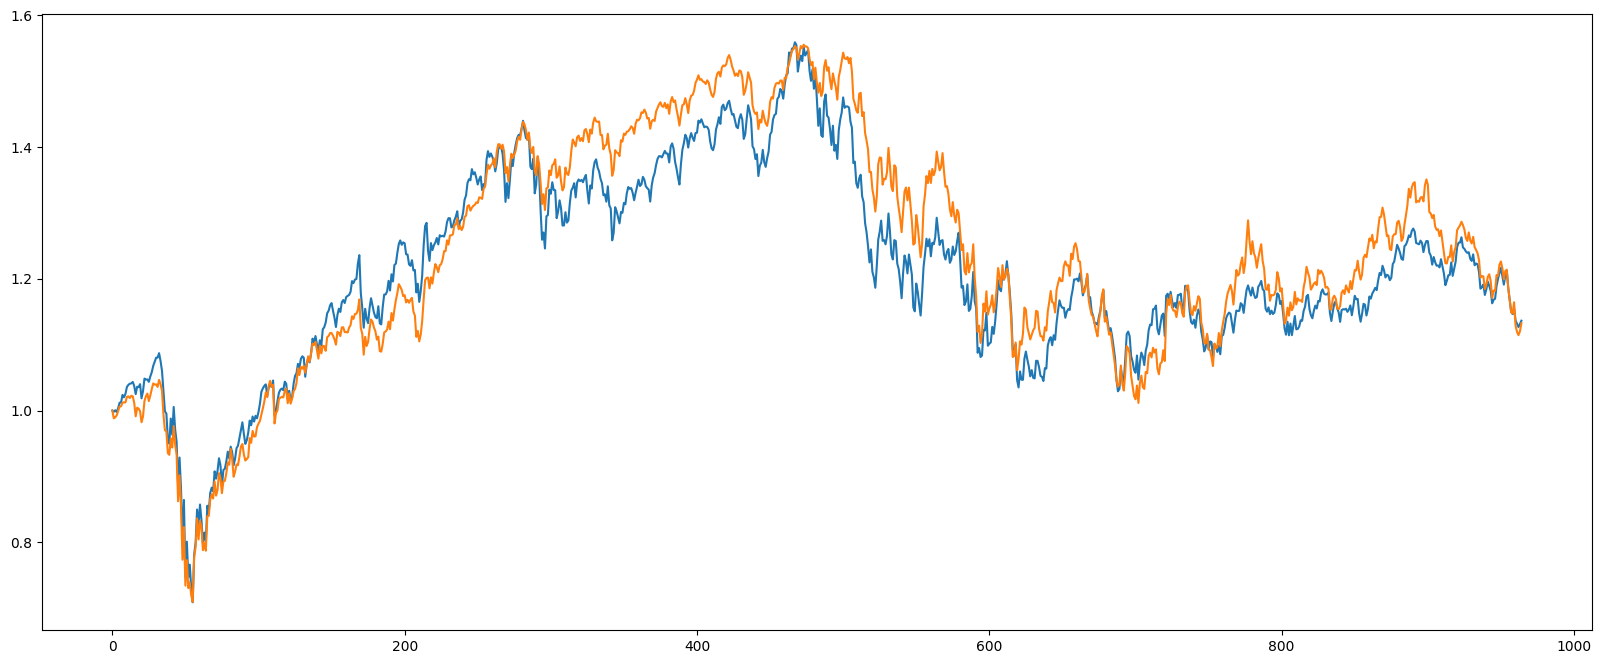

,base_asset,compare_asset,label
0,IEF,LDSF,0
1,IEI,VTC,0
2,IEI,VMBS,0
3,IEI,VGSH,0
4,IEI,VCIT,0
...,...,...,...
445,NXTG,NZAC,1
446,PDP,ROBT,1
447,PDP,XT,1
448,NFTY,RNLC,1


In [29]:
# Plot price comparison for any given asset
asset_1 = "PDP"
asset_2 = "XT"

asset_1_values =  df[asset_1].values / df[asset_1].iloc[0].item()
asset_2_values = df[asset_2].values / df[asset_2].iloc[0].item()

plt.figure( 1 , figsize=(20,8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()


# Co-Intergrated Stocks
df_coint

# Review a Pair's Spread
- STOCK1 - STOCK2 * hedge ratio
- you want it to be as close to zero as possible

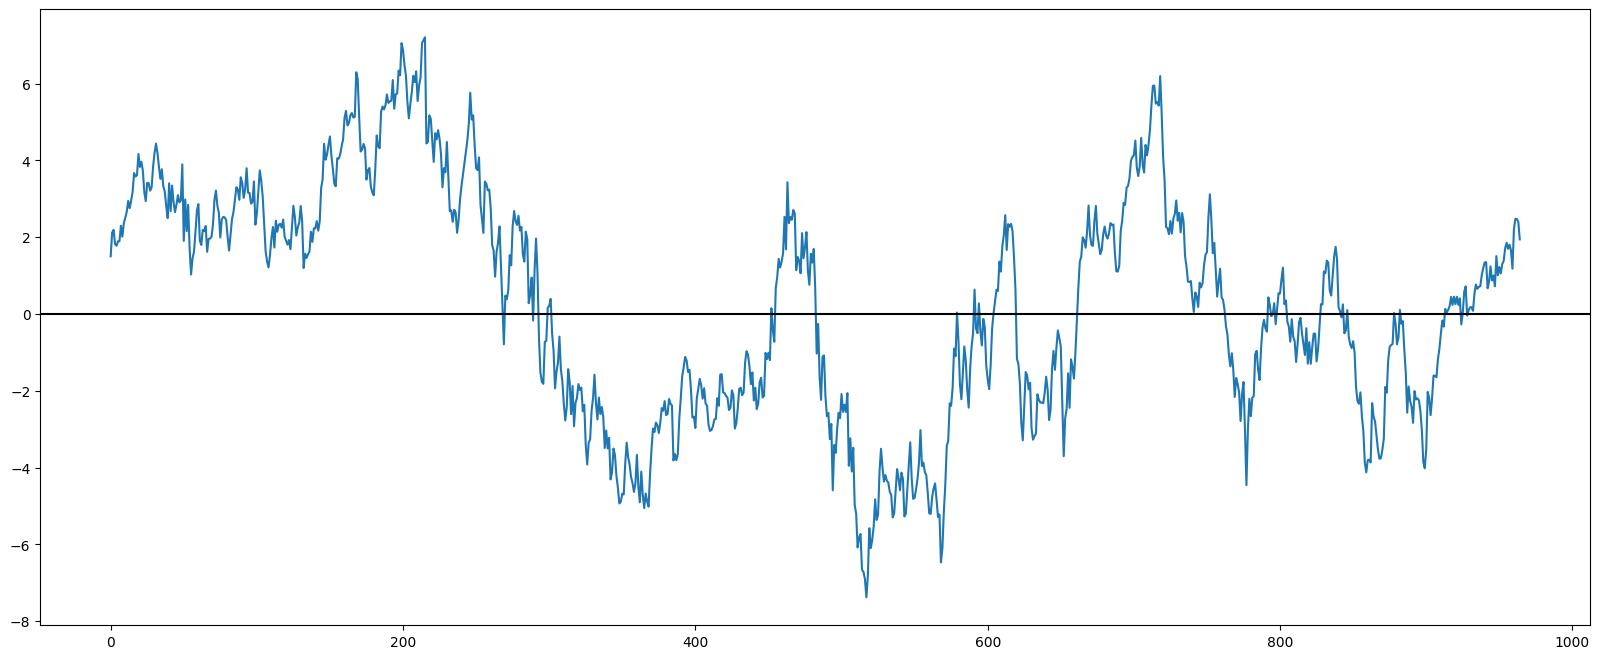

In [30]:
# Plot the spread
# STOCK1 - STOCK2 * hedge ratio


series_1 = df[asset_1].values.astype(float)
series_2 = df[asset_2].values.astype(float)
coint_flag , hedge_ratio = calc_cointergration(series_1 , series_2)


spread = series_1 - (hedge_ratio * series_2)
plt.figure(1 , figsize=(20,8))
plt.plot(spread)
plt.axhline(0, color='black') 
plt.show()


# Z Score
- how tight the band relating these two stocks is getting
- The z-score is a measure of how many standard deviations an element is from the mean.

In [31]:
# calculate z-score
window = 100 
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False,window=window).mean()
std = spread_series.rolling(center=False,window=window).std()
x = spread_series.rolling(center=False,window=1).mean()


z_score = (x - mean ) / std

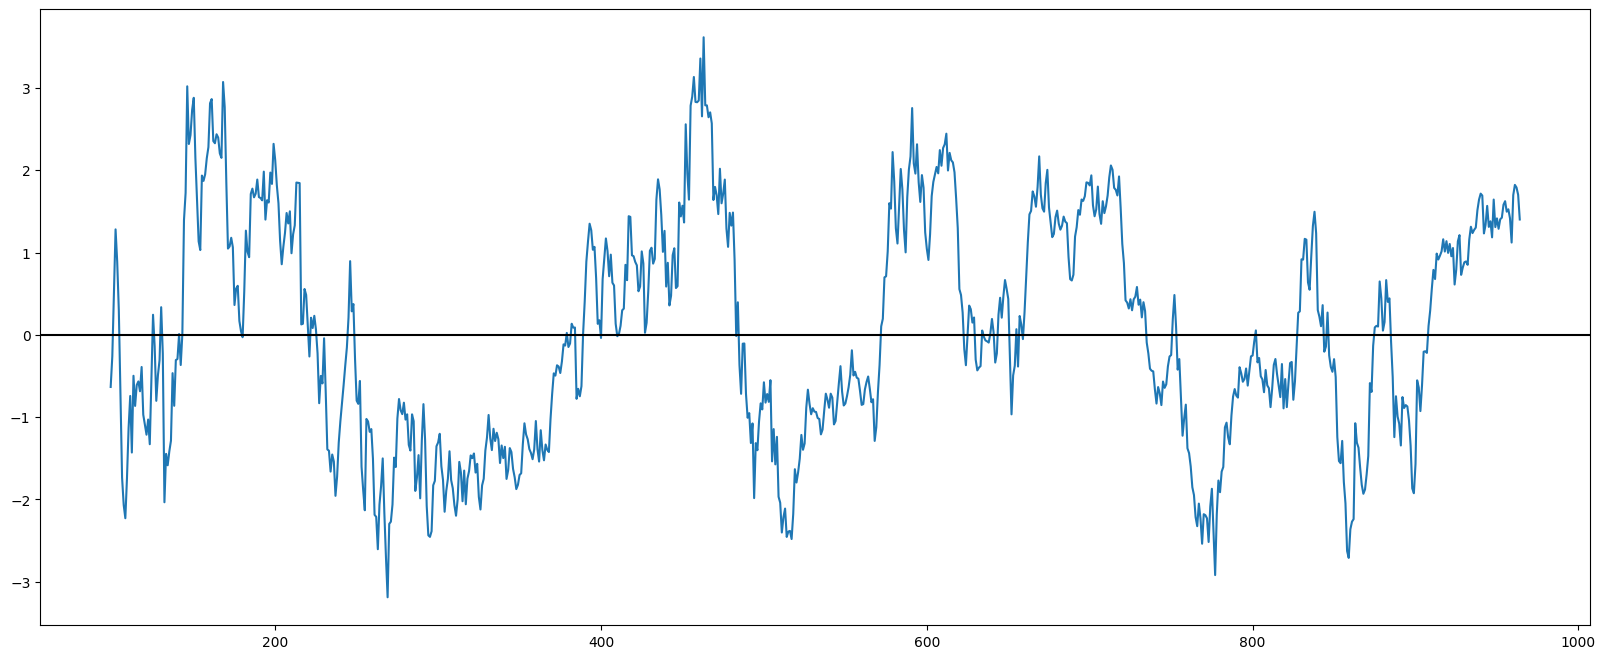

In [32]:
# Display z-score
plt.figure(1 , figsize=(20,8))
plt.plot(z_score)
plt.axhline(0, color='black') 
plt.show()

In [33]:
# Save Z score
# Save Data
capped = []
for z in z_score:
    z = 6 if z > 6 else z
    z = -6 if z <-6 else z
    capped.append(z)
df_save = df[[asset_1, asset_2]].copy()
df_save["Spread"] = spread
df_save["ZScore"] = capped
df_save.dropna(inplace=True)
df_save.columns = ["Asset1", "Asset2", "Spread", "ZScore"]
df_save.to_csv("data-storage/pair_trade.csv")
df_save

,Asset1,Asset2,Spread,ZScore
Date,,,,
2020-05-26,63.970001,42.169998,2.324355,-0.633932
2020-05-27,64.589996,42.400002,2.608123,-0.261761
2020-05-28,65.410004,42.580002,3.165000,0.505980
2020-05-29,66.580002,42.990002,3.735645,1.281058
2020-06-01,66.919998,43.404999,3.468983,0.889955
...,...,...,...,...
2023-10-25,73.599998,48.840000,2.203900,1.697467
2023-10-26,73.269997,48.430000,2.473251,1.821666
2023-10-27,72.949997,48.209999,2.474857,1.790427
